In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

### Imports and setting up workspace

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *

### Input the kaggle dataset

In [ ]:
# Load data. Return a path object.
img_dir='../input/car_data/car_data/train'
path=Path(img_dir)

### Getting the databunch object

**Note:** `valid_pct` set because validation folder not present in the dataset. Throws error if not set and validation folder not found. See [source code.](https://github.com/fastai/fastai/blob/master/fastai/vision/data.py#L102)

In [ ]:
data = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, 
                                  ds_tfms=get_transforms(), 
                                   size=224, bs=34, num_workers=0)
data.normalize(imagenet_stats)

In [ ]:
data.show_batch(rows=2, figsize=(10,10))

In [ ]:
# Class names
data.classes

In [ ]:
len(data.classes)

### Training with resnet34

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, model_dir='/tmp/models')

In [ ]:
learn.fit_one_cycle(4)

Lowest error rate achieved: 23%

### Interpreting results

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

In [ ]:
interp.most_confused(min_val=3)

In [ ]:
learn.save('stage-1')

### Unfreezing, fine-tuning, and learning rates

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
# from the above plot, train again
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-06, 1e-03))

### Training with resnet50

**Question:** Why I want to `do_flip=True`, which is default behavior [according to docs](https://docs.fast.ai/vision.transform.html#Data-augmentation)?

In [ ]:
tfms = get_transforms(do_flip=False)
data50 = ImageDataBunch.from_folder(path, train='.', valid_pct=0.2, ds_tfms=tfms, 
                                   size=224, bs=34, num_workers=0)
data50.normalize(imagenet_stats)

In [ ]:
learn50 = cnn_learner(data50, models.resnet50, metrics=error_rate, model_dir='/tmp/models')

In [ ]:
learn50.lr_find()

In [ ]:
learn50.recorder.plot()

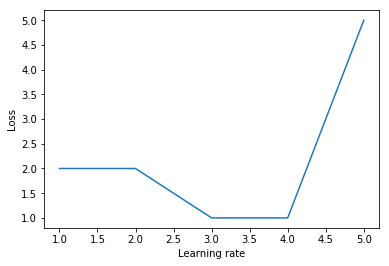

In [22]:
import matplotlib.pyplot as plt
x = [1, 2, 3, 4, 5]
y = [2, 2, 1, 1, 5]
plt.plot(x, y)
plt.xlabel('Learning rate')
plt.ylabel('Loss')
None

In [ ]:
learn50.fit_one_cycle(5, max_lr=slice(1e-06, 1e-01))

Error rate was higher even after 20 epochs (probably because I increased image size to 299). *Does that affect model performance though?*